In [2]:
import ibmseti
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import zipfile

from obspy.core import read
from obspy.signal.trigger import classic_sta_lta
from astropy.convolution import convolve, Box1DKernel
from scipy import ndimage

import cv2
%matplotlib inline
import statsmodels.api as sm
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [3]:
# Find the data in the zip file
mydatafolder = '../data'
zz = zipfile.ZipFile(os.path.join(mydatafolder, 'basic4.zip'))
basic4list = zz.namelist() #list of all the image files 
firstfile = basic4list[1400] #for testing 

label_csv = pd.read_csv('../data/public_list_basic_v2_26may_2017.csv') #labels for basic4 data 
label_csv.index = label_csv.UUID #make ID the index

In [4]:
def spectrogram_raw(in_file):
    '''
    raw np array of spectrogram 
    '''
    
    # Read data into ibmseti object
    aca = ibmseti.compamp.SimCompamp(zz.open(in_file).read())

    # Get the raw complex data
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(32, 6144)
    cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)**2
    
    return spectrogram


def seismogram(in_file):    
    '''
    Sanjoy's Seismogram image processing function 
    Create binary image of highly denoised spectrogram 
    '''
    
    # Read data into ibmseti object
    aca = ibmseti.compamp.SimCompamp(zz.open(in_file).read())

    # Get the raw complex data
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(32, 6144)
    cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)**2

    # Create a new empty spectrogram to contain the smooth spedtrogram values
    smoothedspectro=np.zeros(np.shape(spectrogram))

    # Apply seismogram filtering to data
    for i in range(np.shape(spectrogram)[0]):
        background = convolve(spectrogram[i], Box1DKernel(100))
        smoothedspectro[i]=spectrogram[i] - background
        df = 20
        cft = classic_sta_lta(smoothedspectro[i], int(5 * df), int(10 * df))
        indices_ut = np.where(cft>1.7)
        indices_ut = list(indices_ut[0])
        indices_lt = np.where(cft<0.2)
        indices_lt  = list(indices_lt[0])
        indices = indices_ut + indices_lt
        indices_zero = range(0,6144)
        indices_zero = list(set(indices_zero) - set(indices))
        smoothedspectro[i][indices_zero] = 0
        smoothedspectro[i][indices_ut] = 1
        smoothedspectro[i][indices_lt] = 1
        smoothedspectro[i][:500] = 0

    # Binarize the image
    ndimage.binary_erosion(np.asarray(smoothedspectro), structure=np.ones((100,100))).astype(np.int)
    
    return smoothedspectro

# #Plot siesmo spectrogram
# fig, ax = plt.subplots(figsize=(8, 4))
# cmap = plt.cm.get_cmap("binary")
# ax.imshow(spectrogram, cmap=cmap,aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
# ax.set_axis_off()

In [175]:
def narrow_linear_fit(image, stretch_factor):
    
    '''
    arugments:  the image and a stretch factor
    
    this function applies image processing for smoothing/closing
    it then skeletonizes the image to a line width of one
    these pixel locations are taken and fit to a linear model 
    r^2 is taken to distinguish between narrowband (linear) and narrowbandrd (curved)
    
    returns: linear model object, dependent values for line, independent values for line, spectrogram 
    '''
    
    # IMAGE PROCESSING #
    spectrogram = seismogram(image)
    spectrogram = np.uint8(spectrogram) #prep for openCV 
    kernel = np.ones((11,11),np.uint8) #kernel size for morpho closing 
    spectrogram = cv2.morphologyEx(spectrogram, cv2.MORPH_CLOSE, kernel) #close holes 
    spectrogram = cv2.GaussianBlur(spectrogram, (11,11), 0) #close gaps
    spectrogram[spectrogram > 0] = 255 #make binary

    #skeletonize the band 
    curve = [] #will be a list of points where the band is 
    for row in spectrogram:
        point = np.median(np.array(np.nonzero(row > 0))) 
        curve.append(point)

    #clean up data 
    curve =  np.array(curve).flatten()
    curve = curve[~np.isnan(curve)] # get rid of NAN values (where image is blank)
    X = np.linspace((curve.shape[0]-1), 0, curve.shape[0]).flatten()
    
    #scale data between 0-~32 (height of raw image, minus the dropped NANs)
    scaler = MinMaxScaler()
    curve = scaler.fit_transform(curve.reshape(-1, 1))
    curve = curve*X.shape[0] 
    
    #constrain  edges 
    curve = curve[2:-2] 
    X = X[2:-2]

    #fit a linear regression to the skeletonized line 
    X = sm.add_constant(X)
    linear_fit = sm.OLS(curve, X).fit() 

    return linear_fit, curve, X, spectrogram 

In [96]:
plot_ = False #toggle 
data = np.empty((3,)) #for logging values 
index = ['null'] #for logging values 
stretch = 1 #factor to stretch (affine) image by 

for img_name in basic4list: 
    full_label = label_csv.loc[img_name.split('.')[0]] #ID 
    class_ = full_label[1]
    if class_=='narrowbanddrd' or class_=='narrowband':
        index.append(img_name)
        result, line, x, spectrogram  = narrow_linear_fit(img_name, stretch)
        data = np.vstack((data, [class_, result.rsquared, result.rsquared_adj]))  #log for analysis
        
        print class_
        print result.rsquared, result.rsquared_adj
        
        if plot_ == True:
            fig, (ax1) = plt.subplots(1, 1)
            fig.set_size_inches(7, 7)
            ax1.plot(line, x)
#             ax2.imshow(spectrogram, aspect = 10000)
            plt.show()
            
results = pd.DataFrame(data=data, columns=['class', 'r2', 'adj_r2'], index=index)

narrowbanddrd
0.946073359252 0.943999257685
narrowband
0.997530320339 0.99743533266
narrowband
0.998013478878 0.997937074219
narrowband
0.997322177093 0.997219183904
narrowband
0.997798259301 0.997713576966
narrowband
0.997971207566 0.997893177088
narrowband
0.998186954226 0.998117221696
narrowbanddrd
0.95764216354 0.955716807338
narrowbanddrd
0.959570147804 0.958015153489
narrowband
0.99760543961 0.997513341133
narrowband
0.997663835896 0.997573983431
narrowbanddrd
0.995201747659 0.995017199492
narrowbanddrd
0.996113572363 0.995964094377
narrowband
0.997270895052 0.997165929477
narrowband
0.998080813099 0.998006998219
narrowbanddrd
0.996296388961 0.996153942383
narrowbanddrd
0.991825305958 0.991510894649
narrowbanddrd
0.992081961382 0.991777421435
narrowband
0.997694794175 0.997606132412
narrowbanddrd
0.991313161393 0.990979052215
narrowbanddrd
0.994059530834 0.993831051251
narrowband
0.997216593304 0.9971095392
narrowband
0.997598272283 0.99750589814
narrowband
0.997720086381 0.99763

narrowbanddrd
0.826424219287 0.819748227721
narrowband
0.996972058979 0.996855599709
narrowband
0.997962398877 0.997884029603
narrowband
0.997193527127 0.997085585863
narrowbanddrd
0.970117618184 0.968968295806
narrowbanddrd
0.976460918255 0.975555568957
narrowband
0.997642888227 0.997552230082
narrowband
0.997344441184 0.997242304306
narrowbanddrd
0.99171346743 0.991394754639
narrowbanddrd
0.99654310991 0.996410152599
narrowbanddrd
0.9736460452 0.972632431554
narrowbanddrd
0.990707568218 0.990350166995
narrowbanddrd
0.886907947883 0.882558253571
narrowband
0.983073245641 0.982422216627
narrowbanddrd
0.946632293325 0.944579689222
narrowband
0.98994961142 0.989563058013
narrowbanddrd
0.982999975221 0.982346128114
narrowband
0.997391820498 0.997291505902
narrowband
0.997713051957 0.997625092417
narrowband
0.997534581184 0.997439757383
narrowbanddrd
0.977085222258 0.976203884653
narrowbanddrd
0.794346056166 0.786436289096
narrowbanddrd
0.99589937907 0.995741662881
narrowbanddrd
0.99166550

narrowband
0.997586702904 0.997493883785
narrowband
0.997490012378 0.997393474393
narrowbanddrd
0.988802112246 0.988371424256
narrowband
0.997746888473 0.997660230338
narrowband
0.99769178255 0.997603004956
narrowbanddrd
0.964278208099 0.962904293026
narrowbanddrd
0.995501086617 0.995328051486
narrowband
0.997361651528 0.997260176587
narrowbanddrd
0.99450790167 0.994296667119
narrowbanddrd
0.995249934497 0.99506723967
narrowbanddrd
0.994411742476 0.994196809494
narrowband
0.997684011192 0.997594934699
narrowbanddrd
0.976920250084 0.976032567395
narrowbanddrd
0.99279205557 0.992514826938
narrowbanddrd
0.988833012587 0.988403513071
narrowband
0.997272045426 0.997167124096
narrowband
0.997443767562 0.99734545093
narrowband
0.997117044574 0.997006161673
narrowband
0.997594674568 0.997502162052
narrowbanddrd
0.986234414871 0.985704969289
narrowband
0.994524103617 0.994313492217
narrowband
0.997854186009 0.997771654702
narrowbanddrd
0.994985452638 0.994792585432
narrowband
0.997915885106 0.9

narrowband
0.997578508396 0.997485374103
narrowband
0.966468673641 0.965179007243
narrowband
0.997565581513 0.997471950033
narrowbanddrd
0.994938530639 0.99474385874
narrowband
0.994075594638 0.993847732893
narrowbanddrd
0.699511904916 0.68795467049
narrowband
0.997646232532 0.997555703014
narrowbanddrd
0.948190507622 0.946197834838
narrowband
0.9977278979 0.997640509357
narrowband
0.997751583607 0.997665106053
narrowband
0.997288888568 0.997184615051
narrowband
0.997887645551 0.997806401149
narrowbanddrd
0.991602521188 0.991279541234
narrowband
0.997315710508 0.997212468604
narrowband
0.997644620915 0.997554029412
narrowband
0.997686603196 0.997597626395
narrowbanddrd
0.991574608933 0.99125055543
narrowband
0.99786444652 0.997782309848
narrowbanddrd
0.996472095588 0.996336406957
narrowband
0.997777552124 0.99769207336
narrowbanddrd
0.866928719081 0.861810592892
narrowbanddrd
0.994371532716 0.994155053205
narrowband
0.873379390457 0.868509367013
narrowband
0.998011035071 0.99793453642


narrowband
0.997630537658 0.997539404491
narrowband
0.997713085763 0.997625127523
narrowband
0.996632011579 0.996502473563
narrowband
0.997431415407 0.997332623692
narrowband
0.997540545864 0.997445951474
narrowband
0.973071013998 0.972035283767
narrowband
0.997587922419 0.997495150204
narrowbanddrd
0.882715956998 0.878205032267
narrowbanddrd
0.993889048094 0.993654011482
narrowband
0.997737957075 0.997650955424
narrowband
0.997354071664 0.997252305189
narrowband
0.997775856903 0.997690312937
narrowbanddrd
0.993918899636 0.993685011161
narrowbanddrd
0.755538605459 0.746136244131
narrowband
0.991059952613 0.990716104636
narrowbanddrd
0.996048396789 0.99589641205
narrowband
0.997882399747 0.997800953584
narrowband
0.99557171803 0.995401399493
narrowband
0.997834162919 0.997750861493
narrowband
0.997688098036 0.997599178729
narrowband
0.997973801668 0.997895870963
narrowbanddrd
0.991800978058 0.99148563106
narrowband
0.988241865015 0.987789629054
narrowband
0.99787141218 0.997789543418
na

narrowband
0.997613020317 0.997521213406
narrowbanddrd
0.992563310203 0.992277283672
narrowbanddrd
0.992800870754 0.992523981167
narrowband
0.995046066922 0.994855531035
narrowband
0.997944105748 0.997865032892
narrowband
0.996495773844 0.996360995915
narrowbanddrd
0.994033004654 0.993803504833
narrowbanddrd
0.994728642696 0.994525898184
narrowband
0.997703774748 0.997615458392
narrowbanddrd
0.995183892735 0.99499865784
narrowbanddrd
0.889832460517 0.88559524746
narrowband
0.992182777775 0.991882115382
narrowband
0.994992328347 0.994799725591
narrowbanddrd
0.922141207982 0.919146639058
narrowband
0.997603923731 0.997511766951
narrowbanddrd
0.993139843331 0.992875991151
narrowband
0.998202097896 0.998132947816
narrowband
0.998043559236 0.997968311514
narrowband
0.996886797429 0.996767058869
narrowbanddrd
0.994989221817 0.994796499579
narrowbanddrd
0.982899924118 0.982242228892
narrowbanddrd
0.993523187426 0.99327407925
narrowband
0.99802113699 0.997945026874
narrowband
0.996533420691 0.

narrowbanddrd
0.988998916398 0.988575797798
narrowbanddrd
0.99531896955 0.995138929918
narrowbanddrd
0.994465432611 0.994252564635
narrowband
0.997181769374 0.997073375888
narrowband
0.997609854778 0.997517926116
narrowbanddrd
0.994120218903 0.993894073477
narrowband
0.997440527501 0.997342086251
narrowband
0.997937894625 0.99785858288
narrowbanddrd
0.972720716231 0.971671513009
narrowband
0.997699046221 0.997610547999
narrowband
0.995531096261 0.995359215348
narrowbanddrd
0.887952264825 0.883642736549
narrowband
0.997970903011 0.997892860819
narrowband
0.996909773635 0.996790918774
narrowbanddrd
0.98732676923 0.986839337277
narrowbanddrd
0.994763061041 0.994561640312
narrowbanddrd
0.987955360598 0.987492105236
narrowbanddrd
0.990260508509 0.989885912683
narrowband
0.99738465218 0.997284061879
narrowband
0.996869058777 0.996748637961
narrowbanddrd
0.916058546778 0.912830029347
narrowband
0.997312629435 0.997209269029
narrowband
0.996939153468 0.996821428601
narrowbanddrd
0.99485048929 

narrowband
0.780864267781 0.772435970387
narrowbanddrd
0.996070408297 0.995919270154
narrowband
0.995428383775 0.995252552382
narrowbanddrd
0.987533216474 0.987053724799
narrowbanddrd
0.995033378418 0.99484235451
narrowbanddrd
0.954069934228 0.952303393236
narrowbanddrd
0.994345622302 0.994128146236
narrowband
0.997811805161 0.997727643821
narrowband
0.99377048681 0.993530890149
narrowband
0.997408528277 0.997308856287
narrowband
0.997433150784 0.997334425814
narrowbanddrd
0.994400221326 0.994184845223
narrowbanddrd
0.994857563286 0.994659777258
narrowbanddrd
0.946762704747 0.944715116468
narrowband
0.997416767291 0.997317412187
narrowband
0.996544786093 0.996411893251
narrowband
0.789443210939 0.781344872899
narrowbanddrd
0.994941930824 0.994747389702
narrowbanddrd
0.996147728184 0.995999563883
narrowbanddrd
0.992813524933 0.992537122046
narrowband
0.996798961102 0.996675844221
narrowband
0.997740570355 0.997653669215
narrowband
0.997226440315 0.997119764942
narrowband
0.995708703441 

narrowband
0.997802293734 0.997717766569
narrowband
0.996503093807 0.996368597415
narrowbanddrd
0.994454664039 0.994241381887
narrowband
0.99764716567 0.997556672042
narrowband
0.997734108299 0.997646958618
narrowband
0.991967507806 0.991658565799
narrowbanddrd
0.987620418796 0.987144281057
narrowband
0.99770637038 0.997618153856
narrowband
0.997550263717 0.99745604309
narrowbanddrd
0.942768220633 0.94056699835
narrowband
0.997675569098 0.997586167909
narrowband
0.997672801734 0.997583294109
narrowbanddrd
0.982871664676 0.982212882549
narrowband
0.997837284917 0.997754103568
narrowbanddrd
0.982660059183 0.981993138382
narrowband
0.997718150433 0.997630386988
narrowband
0.99778467128 0.99769946633
narrowband
0.981773383697 0.981072359993
narrowbanddrd
0.994295337888 0.994075927807
narrowbanddrd
0.995501814235 0.995328807091
narrowbanddrd
0.987665951696 0.987191565223
narrowbanddrd
0.993565030005 0.993317531159
narrowbanddrd
0.986018144767 0.985480381104
narrowband
0.997416731999 0.99731

narrowbanddrd
0.986393174668 0.985869835232
narrowbanddrd
0.99459470671 0.994386810815
narrowband
0.997760556838 0.997674424408
narrowband
0.997782750475 0.997697471647
narrowband
0.997049008268 0.996935508586
narrowband
0.997454213098 0.997356298217
narrowband
0.976232663624 0.975318535301
narrowbanddrd
0.995216922739 0.995032958229
narrowbanddrd
0.995062133617 0.994872215679
narrowband
0.997640684442 0.997549941536
narrowbanddrd
0.975915228578 0.974988891216
narrowbanddrd
0.798209481864 0.790448308089
narrowband
0.984029408981 0.98341515548
narrowband
0.997802095668 0.997717560886
narrowband
0.997841467648 0.997758447173
narrowband
0.997771574218 0.997685865534
narrowband
0.99725297743 0.997147322716
narrowbanddrd
0.992404213739 0.992112068114
narrowbanddrd
0.992545404608 0.9922586894
narrowband
0.997782932289 0.997697660454
narrowband
0.997495603217 0.997399280264
narrowbanddrd
0.992554929501 0.992268580636
narrowband
0.997663060138 0.997573177836
narrowbanddrd
0.990504803086 0.9901

narrowband
0.910400893827 0.906954774359
narrowband
0.996964563648 0.996847816096
narrowband
0.996903093924 0.996783982152
narrowband
0.997875518046 0.997793807202
narrowbanddrd
0.996242745253 0.996098235455
narrowbanddrd
0.996306523331 0.996164466536
narrowband
0.99777172158 0.997686018564
narrowband
0.997412306516 0.997312779843
narrowbanddrd
0.716999621074 0.706114991116
narrowbanddrd
0.9923394981 0.992044863412
narrowband
0.996763512429 0.996639032138
narrowband
0.997739334643 0.997652385976
narrowbanddrd
0.99554565618 0.995374335264
narrowbanddrd
0.995343798184 0.995164713499
narrowband
0.997534082912 0.997439239947
narrowbanddrd
0.990499734454 0.990134339626
narrowbanddrd
0.996384775379 0.996245728279
narrowbanddrd
0.984687928212 0.984099002374
narrowband
0.997898851075 0.997818037655
narrowbanddrd
0.989502152393 0.989098389023
narrowband
0.997723088377 0.997635514853
narrowbanddrd
0.989510153419 0.989106697782
narrowband
0.997400150327 0.997300156108
narrowbanddrd
0.989502803191

ValueError: Shape of passed values is (3, 2001), indices imply (3, 2000)

# Analysis 

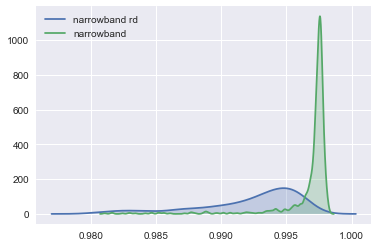

In [183]:
#build a data frame of the results 
#results = pd.DataFrame(data=data, columns=['class', 'r2', 'adj_r2'])

results = results[1:] #first row null 
results[['r2','adj_r2']] = results[['r2','adj_r2']].apply(pd.to_numeric) #string to float 

# split the narrowband and narrowbandrd labels and filter by r^2
nb_rd = results[results['class']=='narrowbanddrd']['adj_r2']
nb_rd = nb_rd[nb_rd>0.98] #filter r^2 values to help find the intersection 
nb = results[results['class']=='narrowband']['adj_r2']
nb = nb[nb>0.98]

#kernel density plot (smoothed histogram)
sb.kdeplot(nb_rd, gridsize=1000, shade=True)
sb.kdeplot(nb, gridsize=1000, shade=True)
plt.legend(['narrowband rd', 'narrowband'])
plt.show()

In [184]:
threshold = 0.9970 #intersection 
def r2_predictions(x):
    if x>threshold: 
        return 'narrowband'
    else: 
        return 'narrowbanddrd'
results['pred'] = results['adj_r2'].apply(r2_predictions) #apply predictions 

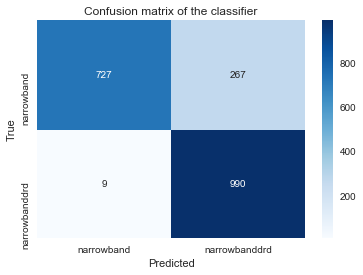

accuracy: 0.861515303562


In [185]:
#create a confusion matrix to sort the predictions and calculate accuracy
labels = ["narrowband", "narrowbanddrd"]
cm = confusion_matrix(results['class'], results['pred'], labels=labels) 
cm = pd.DataFrame(data=cm, columns=labels, index=labels)

fig = plt.figure()
sb.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

correct = cm.values[0][0] + cm.values[1][1]
total = float(cm.values.sum())
accuracy = correct / total
print 'accuracy:', accuracy

# Analysis 

In this go around I was trying to distinguish Narrowband (N) from NarrowbandRD (RD) by fitting the bands to a linear regression. Since N is supposed to be linear and RD is supposed to be curved, their $R^2$ should be a telling feature. I did some light image processing on top of the seismogram processor - morphological closing of the bands, smoothing, adn skeletonizing. I also tried warping the images by stretching them out, thinking that the curves could be exaggerated, but that didn't yeild much. 

Once I got the skeletonized image, where the band was one pixel in width, I got the indeces of the band, scaled it so it would plot nicely, and fit it to a linaer regression. I then looped this over all the N/RD images, and tabulated the results. Above you can see a confusion matrix of the predictions and labels. We got a overall 86% accuracy, calculated as  $\frac{number Correct}{total}$. Narrowband false positive rate is driving the error, meaning that the RD curves may often appear linear; at least with this image processing.  

# Test code below 
might not work... but feel free to play with it if you think it is on to something. 


# Houghlines(P) line detection 

computer vision technique to find lines 

narrowbanddrd False


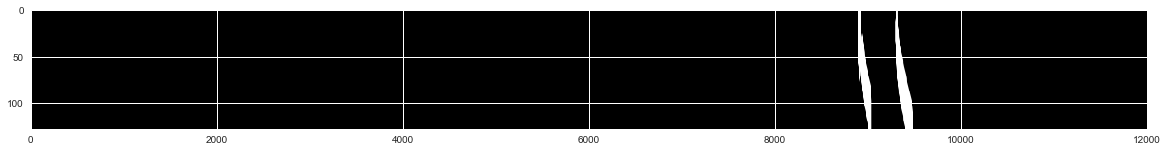

narrowband True


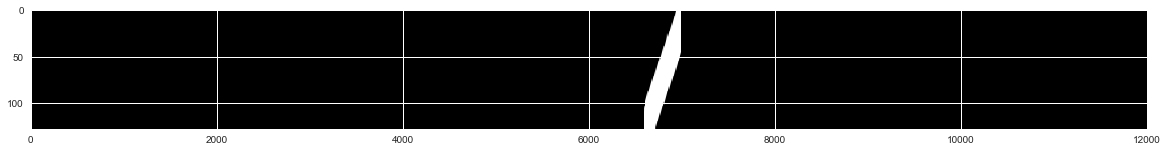

narrowband True


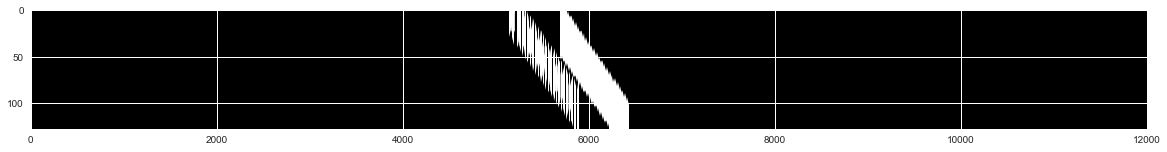

narrowband False


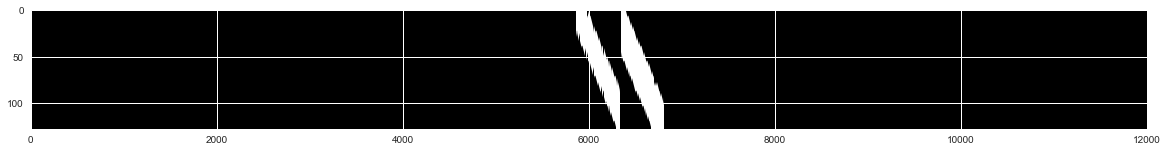

narrowband True


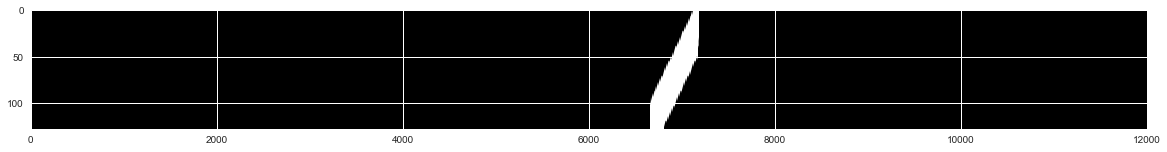

narrowband True


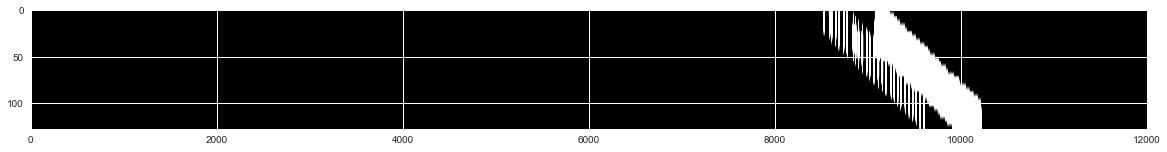

KeyboardInterrupt: 

In [311]:
correct = 0
plot_ = True 
data = np.empty((2,))

for image in basic4list: 
    full_label = label_csv.loc[image.split('.')[0]] #ID 
    class_ = full_label[1]
    if class_=='narrowbanddrd' or class_=='narrowband':
        linear = False #init as narrowbandrd 
        #print i, full_label #debug 

        spectrogram = seismogram(image)
        spectrogram = np.uint8(spectrogram)
        kernel = np.ones((11,11),np.uint8)
        spectrogram = cv2.morphologyEx(spectrogram, cv2.MORPH_CLOSE, kernel) #close holes 
           
        sobel_h = cv2.Sobel(spectrogram, cv2.CV_8UC1, 1, 0, ksize=7) #edge detector 
        sobel_v = cv2.Sobel(spectrogram, cv2.CV_8UC1, 0, 1, ksize=7) #edge detector 
        spectrogram = cv2.addWeighted(sobel_h, 0.5, sobel_v, 0.5, 0) #edge detector 
        
        spectrogram = cv2.GaussianBlur(spectrogram, (11,11), 0) #close gaps
        spectrogram[spectrogram > 0] = 255 #make binary

        
        gray = spectrogram.copy() #need gray scale for houglinesP detector 
        spectrogram = cv2.cvtColor(spectrogram, cv2.COLOR_GRAY2BGR) #color for plotting 
        
        lines = cv2.HoughLinesP(gray,
                                rho = 10,
                                theta = np.deg2rad(1),   
                                threshold = 100,
                                minLineLength = 200,
                                maxLineGap= 1)

        if lines is None: #if we did not find lines
            lines = []
            length = 0
            len_array = [0]
        else:  
            len_array = []
            for i in lines[:][:][:]:
                for x1,y1,x2,y2 in i:
#                     cv2.line(spectrogram,(x1,y1),(x2,y2),(255, 0, 255),2) 
                    length = np.sqrt((y2-y1)**2+(x2-x1)**2) #dist formula
                    len_array.append(length)
                    #print i, length
                    linear = True #for debugging
        print class_  , linear
        
        if plot_ == True:
            spectrogram = np.uint8(cv2.resize(spectrogram, (12000, 128)))
            fig, ax = plt.subplots()
            fig.set_size_inches(20, 20)
            cmap = plt.cm.get_cmap("Blues")
            ax.imshow(spectrogram, aspect = 10)
            plt.show()

        data = np.vstack((data, [class_, linear]))  #for analysis   
narr_res = pd.DataFrame(data=data, columns=['class', 'linear'], index=basic4list)

In [ ]:
d = pd.DataFrame(data)

n = (d.loc[d[0] == 'narrowband'])
nTP = (n.loc[n[1] == 'True'])
narrow_TP = nTP.shape[0]

nFP = (n.loc[n[1] == 'False'])
narrow_FP = nFP.shape[0]

nRD = (d.loc[d[0] == 'narrowbanddrd'])
nRDFN = (nRD.loc[nRD[1] == 'True'])
narrowrd_FN = nRDFN.shape[0]

nRDTN = (nRD.loc[nRD[1] == 'False'])
narrowrd_TN = nRDTN.shape[0]

In [455]:
print 'true positives', narrow_TP
print 'false negatives', narrow_FP
print 'false positives', narrowrd_FN
print 'true neg', narrowrd_TN

true positives 20
false negatives 13
false positives 4
true neg 24


In [456]:
(20+24)/(44+17)

0.7213114754098361